# Closed-Loop MIMO

In [1]:
import numpy as np
from numpy import sqrt, pi
import scipy as sp
from scipy import special
import tensorflow as tf
import time
import datetime
from keras.layers.normalization import BatchNormalization
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import unitary_group
from scipy.stats import ortho_group

In [2]:
# https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth
print(tf.__version__)
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2.2.0
Num GPUs Available:  1


In [3]:
# (n,k) = 2^k messages over n complex-valued channel uses
k = 4
n = 1 # complex-valued dimensions
R = k/n # bits / 2 dims

M = 2**k # constellation size
N = 2*n # real-valued dimensions

Tx = 2 # number of transmit antennas
Rx = 2 # number of receive antennas

Tx_NN = 1024 # neurons in hidden layer at transmitter
Rx_NN = 1024 # neurons in hidden layer at receiver
batch_norm = False

enc_dims = [M+2*Tx*Rx, Tx_NN, Tx_NN, Tx_NN, N*Tx]
dec_dims = [N*Rx+2*Tx*Rx, Rx_NN, Rx_NN, Rx_NN, M]

B = 10240 # minibatch size
lr = 0.001 # learning rate

EsNo_dB_r = [5, 10, 15, 12] 

In [4]:
def normalization(x): # power per tx antenna is 1
    """ x has shape [B, Tx*N]
    """
    Bt = x.shape[0] # assumed to be a multiple of M
    x = tf.reshape(x, [Bt//M, M, Tx*N])
    x = x / tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.square(x), axis=2, keepdims=True), axis=1, keepdims=True)/(Tx*n))
    return tf.reshape(x, [Bt, Tx*N])

def normalization_old(x): # power per tx antenna is 1
    """ x has shape [B, Tx*N]
    """
    return x / tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.square(x), axis=1, keepdims=True), axis=0, keepdims=True)/(Tx*n))
    
def mimo_channel(xr, xi, Hr, Hi, sigma2):
    """ xr,xi has shape [B, Tx*N]
        Hr,Hi have shape [B, Rx, Tx]
        y = H*x + n
    """
    yr = tf.matmul(Hr,xr) - tf.matmul(Hi,xi)
    yi = tf.matmul(Hr,xi) + tf.matmul(Hi,xr)
    yr = yr + tf.random.normal(tf.shape(yr), mean=0.0, stddev=np.sqrt(sigma2))
    yi = yi + tf.random.normal(tf.shape(yi), mean=0.0, stddev=np.sqrt(sigma2))
    return yr, yi

class Encoder(tf.Module):
    def __init__(self, dims, batch_norm=False):
        super().__init__()
        if len(dims) < 2: raise ValueError("Input list has to be at least length 2")
        
        self.layers = []
        for i in range(len(dims)-2):
            #if batch_norm == True:
            #    self.layers.append(tf.keras.layers.BatchNormalization())
            self.layers.append(tf.keras.layers.Dense(dims[i+1], activation="relu"))
        #if batch_norm == True:
        #    self.layers.append(tf.keras.layers.BatchNormalization())
        self.layers.append(tf.keras.layers.Dense(dims[-1], activation=None))
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return normalization(x)
        #return normalization_old(x)

class Decoder(tf.Module):
    def __init__(self, dims, batch_norm=False):
        super().__init__()
        if len(dims) < 2: raise ValueError("Input list has to be at least length 2")
        
        self.layers = []
        for i in range(len(dims)-2):
            if batch_norm == True:
                self.layers.append(tf.keras.layers.BatchNormalization())
            self.layers.append(tf.keras.layers.Dense(dims[i+1], activation="relu"))
        if batch_norm == True:
            self.layers.append(tf.keras.layers.BatchNormalization())
        self.layers.append(tf.keras.layers.Dense(dims[-1], activation="softmax"))
        
    def __call__(self, x, training):
        for layer in self.layers:
            if "batch_normalization" in layer.name:
                x = layer(x, training=training)
            else:
                x = layer(x)
        return x

class AE(tf.Module):
    """ AE: communications autoencoder
    
    Args:
        enc_dims: dimensions (neurons per layer) for encoder
        dec_dims: dimensions (neurons per layer) for decoder
    
    """
    def __init__(self, enc_dims, dec_dims, batch_norm=False):
        super().__init__()
        self.Encoder = Encoder(enc_dims, batch_norm)
        self.Decoder = Decoder(dec_dims, batch_norm)
    
    def __call__(self, ohv, Hr, Hi, sigma2, training=False):
        Hr = tf.repeat(Hr, M, axis=0)
        Hi = tf.repeat(Hi, M, axis=0)
        HrR = tf.reshape(Hr, [-1, Tx*Rx])
        HiR = tf.reshape(Hi, [-1 ,Tx*Rx])
        
        x = self.Encoder(tf.concat([ohv, HrR, HiR], axis=1))
        
        xr = tf.reshape(x[:,0:N*Tx//2], [-1, Tx, N//2])
        xi = tf.reshape(x[:,N*Tx//2:N*Tx], [-1, Tx, N//2])
    
        yr,yi = mimo_channel(xr, xi, Hr, Hi, sigma2)
        
        yr = tf.reshape(yr, [-1, Rx*N//2])
        yi = tf.reshape(yi, [-1, Rx*N//2])
        y = tf.concat([yr, yi], axis=1)
        
        return self.Decoder(tf.concat([y, HrR, HiR], axis=1), training)

# Training Routine (Eager)

In [5]:
@tf.function # debug in eager mode, then compile into a static graph (faster)
def train_step_eager(sigma2):
    #indices = tf.random.uniform(shape=(B,), minval=0, maxval=M, dtype=tf.dtypes.int32)
    indices = tf.tile(tf.range(M), [B//M])
    ohv = tf.one_hot(indices, depth=M)
    
    if True:
    #H = (tf.random.normal([B//M, Rx, Tx])+1j*tf.random.normal([B//M, Rx, Tx]))/tf.sqrt(2)
        Hr = tf.random.normal([B//M, Rx, Tx])/np.sqrt(2)
        Hi = tf.random.normal([B//M, Rx, Tx])/np.sqrt(2)
    else: # does not work with eager mode
        num_ch = B//M
        U = unitary_group.rvs(2,num_ch)
        V = unitary_group.rvs(2,num_ch)
        EV1 = 1.0
        EV2 = 0.5
        Sigma = np.tile(np.array([[EV1, 0],[0, EV2]]), (num_ch,1,1))
        V_H = np.transpose(np.conj(V), (0,2,1))
        Htmp = np.matmul(U, np.matmul(Sigma, V)) 

        Hr = tf.convert_to_tensor(np.real(Htmp), dtype=tf.float32)
        Hi = tf.convert_to_tensor(np.imag(Htmp), dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        qxy = model(ohv, Hr, Hi, sigma2, training=True)
        epsilon = 1e-6 # to avoid log(0) = -Inf
        L = -M*tf.reduce_mean(ohv*tf.math.log(qxy+epsilon)/np.log(2))
        
    grads = tape.gradient(L, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))    
    return L

In [6]:
iterations = 500000
print_interval = 1000

log_dir = "logs/closed_loop/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_summary_writer = tf.summary.create_file_writer(log_dir)

model = AE(enc_dims, dec_dims, batch_norm)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

loss_sv = []
total_iter = 0 
for EsNo_dB in EsNo_dB_r:
    print("EsNo = {:.1f} dB".format(EsNo_dB), flush=True)
    EsNo_r = 10**(EsNo_dB/10)
    sigma2 = 1/(2*EsNo_r) # noise power per real dimension
    t = tqdm(range(1, iterations+1), desc="loss")
    for i in t:
        L = train_step_eager(sigma2)
        total_iter = total_iter + 1

        if i%print_interval==0 or i==1:
            with train_summary_writer.as_default():
                tf.summary.scalar('loss', L, step=total_iter)

            t.set_description("loss={:.5f}".format(L))
            t.refresh() # to show immediately the update
            loss_sv.append(L)

EsNo = 5.0 dB


loss=0.29903: 100%|██████████| 500000/500000 [3:49:08<00:00, 36.37it/s]  

EsNo = 10.0 dB



loss=0.03276:  75%|███████▌  | 375985/500000 [2:52:06<56:30, 36.57it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

loss=0.02439:  86%|████████▋ | 432409/500000 [3:17:52<30:53, 36.47it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

loss=0.02901:  98%|█████████▊| 488553/500000 [3:43:33<05:13, 36.47it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To 

loss=0.00537:  73%|███████▎  | 367425/500000 [2:47:51<1:00:32, 36.49it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

loss=0.00705:  76%|███████▌  | 378365/500000 [2:52:51<55:29, 36.53it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

loss=0.00555:  85%|████████▍ | 423025/500000 [3:13:14<35:07, 36.52it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To c

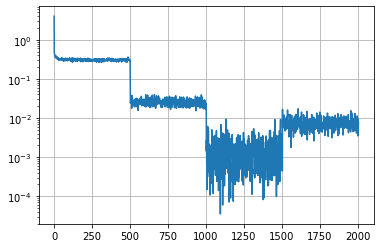

In [7]:
plt.semilogy(loss_sv)
plt.grid()

# Symbol Error Rate

In [8]:
@tf.function
def get_SER(L, sigma2):
    s = tf.tile(tf.range(M, dtype=tf.dtypes.int64), [L//M])
    ohv = tf.one_hot(s, depth=M)
    
    Hr = tf.random.normal([L//M, Rx, Tx])/np.sqrt(2)
    Hi = tf.random.normal([L//M, Rx, Tx])/np.sqrt(2) 
    
    pxy = model(ohv, Hr, Hi, sigma2)
    shat = tf.math.argmax(pxy, axis=1)
    err_vec = tf.cast(s != shat, dtype = tf.dtypes.int64)
    
    return tf.reduce_sum(err_vec)

In [9]:
minErr = 500 # 50k = 8h
maxSym = minErr/1e-5
L = B # blocks 

SNR_dB = np.arange(0, 25, 1)
SNR_r = 10**(SNR_dB/10)

SNRlen = len(SNR_dB)
SymErrs = np.zeros([SNRlen])
Syms = np.zeros([SNRlen])

t = tqdm(range(SNRlen), desc="SNR=")
for II in t:
    #print("SNR = {} dB".format(SNR_dB[II]))
    t.set_description("SNR={:.1f}".format(SNR_dB[II]))
    t.refresh() # to show immediately the update
    totErr, totSym = 0, 0
    sigma2 = 1/(2*SNR_r[II])

    while ((totErr < minErr) and (totSym <= maxSym)):
        thisErr = get_SER(L,sigma2)
        totErr = totErr + np.asarray([thisErr.numpy()])
        totSym = totSym + L
    
    #print(totErr)
    SymErrs[II] = totErr
    Syms[II] = totSym

print(SymErrs)
SER = SymErrs/Syms
print(SER)

SNR=4.0:  16%|█▌        | 4/25 [00:00<00:04,  4.97it/s]

SNR=5.0:  20%|██        | 5/25 [00:00<00:04,  4.96it/s]

SNR=6.0:  24%|██▍       | 6/25 [00:01<00:03,  5.65it/s]

SNR=7.0:  28%|██▊       | 7/25 [00:01<00:02,  6.10it/s]

SNR=8.0:  32%|███▏      | 8/25 [00:01<00:02,  6.38it/s]

SNR=9.0:  36%|███▌      | 9/25 [00:01<00:02,  6.50it/s]

SNR=10.0:  40%|████      | 10/25 [00:01<00:02,  6.44it/s]

SNR=24.0: 100%|██████████| 25/25 [01:06<00:00,  2.67s/it]

[3620. 2992. 2246. 1679. 1227.  873. 1043.  755.  663.  528.  510.  503.
  514.  513.  505.  503.  501.  500.  503.  500.  505.  500.  504.  500.
  500.]
[3.53515625e-01 2.92187500e-01 2.19335937e-01 1.63964844e-01
 1.19824219e-01 8.52539062e-02 5.09277344e-02 3.68652344e-02
 2.15820313e-02 1.28906250e-02 7.11495536e-03 3.77854567e-03
 1.79268973e-03 9.45238797e-04 5.24642620e-04 3.07006836e-04
 1.66414222e-04 1.12767032e-04 1.01072209e-04 8.22022306e-05
 7.38269555e-05 5.34224562e-05 6.77011692e-05 6.52782420e-05
 6.35782878e-05]


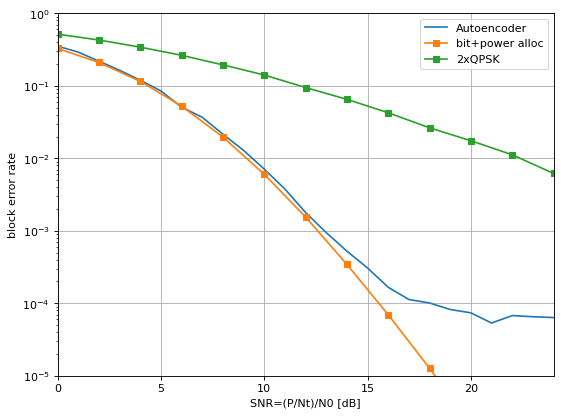

In [11]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

#plt.semilogy(SNR_dB-10*np.log10(2), SER, label='Autoencoder')
plt.semilogy(SNR_dB, SER, label='Autoencoder')

snr_baseline = np.arange(0,28,2)
bler_baseline = np.array([0.32788, 0.21021, 0.11545, 0.052686, 0.019688, 0.0060319, 0.0015539, 0.0003448, 6.9515e-05, 1.2716e-05, 2.0578e-06, 3.2932e-07, 5.236e-08, 4.4919e-09])
plt.semilogy(snr_baseline, bler_baseline, marker='s', linestyle='solid', label='bit+power alloc')

snr_bQPSK = np.arange(0,28,2)
bler_bQPSK = np.array([0.51663, 0.42939, 0.34221, 0.26423, 0.1949, 0.14124, 0.09486, 0.06518, 0.04256, 0.02639, 0.0175, 0.0112, 0.0062, 0.0046])
plt.semilogy(snr_bQPSK, bler_bQPSK, marker='s', linestyle='solid', label='2xQPSK')

plt.xlabel('SNR=(P/Nt)/N0 [dB]')
plt.ylabel('block error rate')
plt.ylim(1e-5, 1)
plt.xlim(0, 24)
plt.legend()
plt.grid()
plt.show()

# Fixed Eigenvalues

In [12]:
minErr = 10000 # 10k = 5 mins
maxSym = minErr/1e-5

EV2 = 0.5
EV1_r = np.arange(0.5, 1.5, 0.1)
snr = 12

L = B
replace = L//M
print(replace, flush=True)

SymErrs = np.zeros(len(EV1_r))
Syms = np.zeros(len(EV1_r))

II = 0
for EV1 in tqdm(EV1_r):
    totErr, totSym = 0,0
    
    snr_linear = np.power(10, snr/10)
    sigma2 = 1/(2*snr_linear)
    
    E = np.array([[EV1, 0], [0, EV2]])
    
    while ((totErr < minErr) and (totSym < maxSym)):
        # =============================== #
        s = tf.tile(tf.range(M, dtype=tf.dtypes.int64), [L//M])
        ohv = tf.one_hot(s, depth=M)
        #Hr = tf.random.normal([L//M, Rx, Tx])/np.sqrt(2)
        #Hi = tf.random.normal([L//M, Rx, Tx])/np.sqrt(2) 
        
        Hr = np.random.normal(size=[L//M, Rx, Tx])/np.sqrt(2)
        Hi = np.random.normal(size=[L//M, Rx, Tx])/np.sqrt(2)
        
        for i in range(replace): 
            V = unitary_group.rvs(2)
            U = unitary_group.rvs(2)
            #Htmp = (np.matmul(U,np.matmul(E,np.conj(V).T)))
            Htmp = (np.matmul(U,np.matmul(E,np.conj(V).T)))
            Hr[i,:,:] = np.real(Htmp)
            Hi[i,:,:] = np.imag(Htmp)
        
        Hr = tf.convert_to_tensor(Hr, dtype=tf.float32)
        Hi = tf.convert_to_tensor(Hi, dtype=tf.float32)
        
        # check power
        if False:
            Hr = tf.repeat(Hr, M, axis=0)
            Hi = tf.repeat(Hi, M, axis=0)
            HrR = tf.reshape(Hr, [-1, Tx*Rx])
            HiR = tf.reshape(Hi, [-1 ,Tx*Rx])
            x = model.Encoder(tf.concat([ohv, HrR, HiR], axis=1))

            i = 100
            x = x[i*M:(i+1)*M,:]
            Pwr = tf.reduce_mean(tf.reduce_sum(x**2, axis=1))

            print(x)
            print(Pwr)
            sys.exit("")
        
        pxy = model(ohv, Hr, Hi, sigma2)
        shat = tf.math.argmax(pxy, axis=1)
        err_vec = tf.cast(s != shat, dtype = tf.dtypes.int64)
        
        # =============================== #
        
        if replace == 0:
            print("tbd")
            #totErr = totErr + np.sum(not_correct)
            #totSym = totSym + frames*batch*M
        else:
            t = tf.reduce_sum(err_vec[0:replace*M])
            totErr = totErr + t.numpy()
            totSym = totSym + replace*M
    
    SymErrs[II] = totErr
    Syms[II] = totSym
    II = II + 1
    
SER = SymErrs/Syms
print(SymErrs)
print(SER)

640


100%|██████████| 10/10 [04:20<00:00, 26.10s/it]

[10319. 10165. 10131. 10205. 10028. 10053. 10046. 10019. 10001. 10004.]
[0.11196832 0.07090541 0.04122314 0.02372814 0.01341503 0.00798161
 0.00469404 0.00281965 0.001681   0.000975  ]


In [13]:
print('EV1_r = ', EV1_r)
print('SER = ', SER)

EV1_r =  [0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4]
SER =  [0.11196832 0.07090541 0.04122314 0.02372814 0.01341503 0.00798161
 0.00469404 0.00281965 0.001681   0.000975  ]
